## 21. 정책 기반 알고리즘

### 21.2. A2C

In [1]:
import Base.Iterators as It
import StatsBase as SB
import ReinforcementLearning as RL
import ProgressMeter as PM
import Distributions as Dist
import IntervalSets as IS
using Random: MersenneTwister
import Flux, Zygote, Functors
import Optimisers as Opt
import Plots

롤아웃 버퍼

In [2]:
mutable struct SARVP{A}
    const sta::Vector{Float32}    # state (상태)
    const act::A                  # action (행동)
    const rew::Float32            # reward (보상)
    const done::Bool              # done (에피소드 종료 여부)
    const val::Float32            # state_value (V, 상태 가치)
    const logp::Float32           # log prob of action (P, 행동 로그확률)
    ret::Float32                  # return (이득)
    adv::Float32                  # advantage (어드밴티지)
end

In [3]:
mutable struct RolloutBuffer{A}
    const buffer::Vector{SARVP{A}}
    const size::Int64
    ptr::Int64
    curr_rew_sum::Float32   # 현재 에피소드 누적 보상
    RolloutBuffer(::Type{A}, size) where A = begin
        buffer = Vector{SARVP{A}}(undef, size)
        new{A}(buffer, size, 0, 0.f0)
    end
end

In [4]:
Base.length(b::RolloutBuffer) = b.ptr

function Base.empty!(b::RolloutBuffer)
    reset_curr_rew_sum_if_last_done!(b)
    b.ptr = 0
end

In [5]:
reset_curr_rew_sum_if_last_done!(b::RolloutBuffer) =
    b.ptr > 0 && b.buffer[b.ptr].done && (b.curr_rew_sum = 0)

reset_curr_rew_sum_if_last_done! (generic function with 1 method)

In [6]:
function Base.push!(b::RolloutBuffer{A}, sta, act, rew, done, val, logp) where A
    @assert b.ptr < length(b.buffer)
    reset_curr_rew_sum_if_last_done!(b)

    b.ptr += 1
    isa(act, AbstractArray) && (act = vec(act))
    b.buffer[b.ptr] = SARVP(sta, A(act), rew, done, val, logp, 0.f0, 0.f0)
    
    b.curr_rew_sum += rew
end

In [7]:
Base.iterate(b::RolloutBuffer, state = 1) =
    state > b.ptr ? nothing : (b.buffer[state], state + 1)


이득 및 GAE 계산

In [8]:
function set_last_epi_ret_adv!(b, last_val, gamma, gae_lambda)
    @assert b.ptr > 0
    next_ret = next_val = last_val
    next_adv = 0.f0
    for i in b.ptr:-1:1
        x = b.buffer[i]
        x.ret = x.rew + gamma * next_ret
        delta = x.rew + gamma * next_val - x.val
        x.adv = delta + gamma * gae_lambda * next_adv
        i > 1 && b.buffer[i - 1].done && break
        next_ret = x.ret
        next_val = x.val
        next_adv = x.adv
    end
end

set_last_epi_ret_adv! (generic function with 1 method)

In [9]:
function get_batch(b::RolloutBuffer{A}, norm_adv) where A
    sta = hcat(map(x -> x.sta, b)...)
    act = map(x -> x.act, b)
    act = A <: Vector ? hcat(act...) : act'
    rew = map(x -> x.rew, b)'
    done = map(x -> x.done, b)'
    val = map(x -> x.val, b)'
    logp = map(x -> x.logp, b)'
    ret = map(x -> x.ret, b)'
    adv = map(x -> x.adv, b)'
    if norm_adv
        adv_m, adv_s = SB.mean_and_std(adv)
        adv = (adv .- adv_m) ./ (adv_s + 0.000001f0)
    end
    (;sta, act, rew, done, val, logp, ret, adv)
end

get_batch (generic function with 1 method)

하이퍼 파라미터

In [10]:
Base.@kwdef mutable struct PolGradCfg
    n_steps::Int64 = 30
    pi_lr::Float32 = 0.0001 
    v_lr::Float32 = 0.001
    
    gamma::Float32 = 0.99
    gae_lambda::Float32 = 0.95
    norm_adv::Bool = false
    
    v_iter::Float32 = 10
    ent_coef::Float32 = 0
    max_grad_norm::Float32 = 1   

    state_dim::Int64 = 0
    action_dim::Int64 = 0
    
    conti_action::Bool = false
    # 연속 행동 공간용
    action_limit::Float32 = 1.0
    min_std::Float32 = 0.0f0
    max_std::Float32 = 1.0f0
    # 이산 행동 공간용
    action_space::Base.OneTo = Base.OneTo(1)
end

PolGradCfg

In [11]:
struct A2c end

모델 정의

In [12]:
mutable struct ActorCritic{A,C}
    actor::A
    critic::C
end

In [13]:
mutable struct PolGradModel{A,C,PO,VO,Algo}
    net::ActorCritic{A,C}
    pi_opt::PO
    v_opt::VO
    cfg::PolGradCfg
    algo::Algo
    rng::MersenneTwister
end

In [14]:
init(rng) = Flux.glorot_uniform(rng)

function PolGradModel(cfg, algo, rng)
    act_out_dim = cfg.action_dim * (cfg.conti_action ? 2 : 1)
    actor = Flux.Chain(
        Flux.Dense(cfg.state_dim => 256, Flux.relu; init = init(rng)),
        Flux.Dense(256 => act_out_dim; init = init(rng))
    )
    critic = Flux.Chain(
        Flux.Dense(cfg.state_dim => 256, Flux.relu; init = init(rng)),
        Flux.Dense(256 => 1; init = init(rng)),
    )
    net = ActorCritic(actor, critic)
    pi_opt = Opt.setup(Opt.Adam(cfg.pi_lr), net.actor)
    v_opt = Opt.setup(Opt.Adam(cfg.v_lr), net.critic)
    PolGradModel(net, pi_opt, v_opt, cfg, algo, rng)
end

PolGradModel

전체 실행 함수

In [15]:
function run(model, env, buffer, tot_steps)
    train_rewards, test_rewards = Float32[], Float32[]
    gamma, gae_lambda = model.cfg.gamma, model.cfg.gae_lambda
    RL.reset!(env)
    cum_steps = 0
    pm_cum_steps = 0 # 줄리아 노트북용 (진행바 간격 조정)
    p = PM.Progress(tot_steps)
    while cum_steps < tot_steps
        steps = 0
        while steps < model.cfg.n_steps
            n = model.cfg.n_steps - steps
            steps += collect_rollouts(model, env, buffer, n)
            if RL.is_terminated(env)
                set_last_epi_ret_adv!(buffer, 0.f0, gamma, gae_lambda)
                push!(train_rewards, buffer.curr_rew_sum)
                push!(test_rewards, run_test_mode(model, env))
                RL.reset!(env)
            end
        end
        cum_steps += steps
        if cum_steps - pm_cum_steps > tot_steps * 0.1
            PM.update!(p, cum_steps)
            pm_cum_steps = cum_steps
        end
        if !RL.is_terminated(env)
            last_val = model.net.critic(RL.state(env))[1]
            set_last_epi_ret_adv!(buffer, last_val, gamma, gae_lambda)
        end
        train(model, buffer)
        empty!(buffer)
    end
    train_rewards, test_rewards
end

run (generic function with 1 method)

In [16]:
function collect_rollouts(model, env, buffer, n)
    steps = 0
    for _ in 1:n
        steps += 1
        state = copy(RL.state(env))
        action, value, log_prob = get_action_v_logp(model, state)    
        action_ = length(action) == 1 ? action[1] : action    
        env(action_)
        done = RL.is_terminated(env)
        push!(buffer, state, action, RL.reward(env), done, value, log_prob)
        done && break
    end
    steps
end

collect_rollouts (generic function with 1 method)

In [17]:
function run_test_mode(model, env)
    RL.reset!(env)
    rew_sum = 0.f0
    while true
        action = get_action_v_logp(model, RL.state(env), false)[1]
        action = length(action) == 1 ? action[1] : action
        env(action)
        rew_sum += RL.reward(env)
        RL.is_terminated(env) && break
    end
    rew_sum
end

run_test_mode (generic function with 1 method)

행동 선택 함수

In [18]:
function get_action_v_logp(model, state, train_mode = true)
    @assert ndims(state) == 1
    cfg, actor = model.cfg, model.net.actor
    actions, log_probs, _ = cfg.conti_action ?
        get_conti_action_logp(actor, state, cfg, model.rng, train_mode) :
        get_discrete_action_logp(actor, state, cfg, model.rng, train_mode)
    action = cfg.conti_action ? actions[:, 1] : actions[1, 1]
    !train_mode && return action, nothing, nothing
    state_values = model.net.critic(state)
    action, state_values[1], log_probs[1]
end


get_action_v_logp (generic function with 2 methods)

In [19]:
function get_conti_action_logp(actor, state, cfg, 
    rngOrAct::Union{AbstractArray, MersenneTwister}, train_mode = true)
    actor_out = actor(state)
    mu = actor_out[1:cfg.action_dim, :] # 벡터면 행렬로
    logstd = actor_out[cfg.action_dim+1:end, :]
    std = clamp.(exp.(logstd), cfg.min_std, cfg.max_std)
    if isa(rngOrAct, AbstractArray) # 행동이 주어지면
        actions = rngOrAct
    else
        actions = mu 
        if train_mode
            actions = actions .+ randn(rngOrAct, Float32, size(mu)) .* std
        end
        limit = cfg.action_limit
        actions = map(v -> clamp(v, -limit, limit), actions)
    end
    log_probs = Float32[]
    if train_mode 
        log_probs = sum(Dist.normlogpdf.(mu, std, actions); dims=1)
    end
    actions, log_probs, logstd
end

get_conti_action_logp (generic function with 2 methods)

In [20]:
function get_discrete_action_logp(actor, state, cfg, 
    rngOrAct::Union{AbstractArray, MersenneTwister}, train_mode = true)
    actor_out = actor(state)
    action_probs = Flux.softmax(actor_out)[:,:] # 벡터면 행렬로
    if isa(rngOrAct, AbstractArray) # 행동이 주어지면
        actions = rngOrAct
    else
        as = collect(cfg.action_space)
        weis = SB.Weights.(eachcol(action_probs))
        if train_mode
            as = collect(cfg.action_space)
            actions = [SB.sample(rngOrAct, as, w) for w in weis]
        else
            actions = [findmax(w)[2] for w in weis]
        end
    end
    log_probs = Float32[]
    if train_mode
        act_idx = CartesianIndex.(actions', 1:length(actions))
        log_probs = log.(action_probs[act_idx])'
    end
    actions, log_probs, action_probs
end

get_discrete_action_logp (generic function with 2 methods)

모델 훈련 함수

In [21]:
function train(model, buffer)
    cfg, algo, net = model.cfg, model.algo, model.net
    batch = get_batch(buffer, cfg.norm_adv)
    pi_iter = hasproperty(algo, :iter) ? algo.iter : 1
    for _ in 1:pi_iter
        actor_loss_fn = get_actor_loss_fn(batch, cfg, algo)
        grad = Zygote.gradient(actor_loss_fn, net.actor)
        grad = clip_grad_norm(grad[1], cfg.max_grad_norm)
        model.pi_opt, net.actor = Opt.update(model.pi_opt, net.actor, grad)
        pi_iter > 1 && algo.curr_kl > 1.5 * algo.max_kl && break
    end
    for _ in 1:cfg.v_iter
        critic_loss_fn = get_critic_loss_fn(batch)
        grad = Zygote.gradient(critic_loss_fn, net.critic)
        grad = clip_grad_norm(grad[1], cfg.max_grad_norm)
        model.v_opt, net.critic = Opt.update(model.v_opt, net.critic, grad)
    end
end

train (generic function with 1 method)

In [22]:
# 가치 기반 코드의 동명 함수와 동일
function clip_grad_norm(grad, max_norm)
    sumsqr = 0.f0
    sqr = g -> isnothing(g) ? nothing : (sumsqr += sum(g .* g))
    _ = Functors.fmap(sqr, grad)
    norm = sqrt(sumsqr)
    if norm > max_norm
        f = g -> isnothing(g) ? nothing : g .* (max_norm / norm)
        return Functors.fmap(f, grad)
    end
    grad
end

clip_grad_norm (generic function with 1 method)

In [23]:
function get_actor_loss_fn(batch, cfg, algo)
    actor -> begin
        if cfg.conti_action
            _, sltd_logp, logstd =
                get_conti_action_logp(actor, batch.sta, cfg, batch.act)
        else
            _, sltd_logp, action_probs =
                get_discrete_action_logp(actor, batch.sta, cfg, batch.act)
        end
            
        actor_loss = -get_policy_objective(batch, sltd_logp, algo)

        if cfg.conti_action
            entropy = (log(2.f0π) + 1) / 2 + SB.mean(logstd)
        else
            n = size(action_probs, 2)
            entropy = -sum(action_probs .* log.(action_probs)) / n
        end

        actor_loss - entropy * cfg.ent_coef
    end
end

get_actor_loss_fn (generic function with 1 method)

In [24]:
get_policy_objective(batch, sltd_logp, ::A2c) = 
    SB.mean(sltd_logp .* batch.adv)

get_policy_objective (generic function with 1 method)

In [25]:
function get_critic_loss_fn(batch)
    critic -> begin
        state_values = critic(batch.sta)
        Flux.Losses.mse(state_values, batch.ret)
    end
end

get_critic_loss_fn (generic function with 1 method)

카트폴 결과

In [26]:
# 가치 기반 코드의 동명 함수와 동일
function plot_results(train_rew, test_rew, title)
    f = (cum, v) -> 0.95 * cum + 0.05 * v
    train_rew_avg = accumulate(f, train_rew; init = train_rew[1])
    test_rew_avg = accumulate(f, test_rew; init = test_rew[1])
    rew, label = [train_rew_avg, test_rew_avg], ["train" "test"]
    Plots.plot(rew, title=title, xlim=(0,length(train_rew)), label=label)
end

plot_results (generic function with 1 method)

In [27]:
function main(tot_steps, cfg, algo)
    rng = MersenneTwister(1)
    env = RL.CartPoleEnv(;T=Float32, continuous=cfg.conti_action, rng=rng)
    cfg.state_dim = length(RL.state_space(env))
    AS = RL.action_space(env)
    if cfg.conti_action
        cfg.action_dim = isa(AS, IS.Interval) ? 1 : length(AS)
        # 행동 공간이 0을 중심으로 대칭, 모든 차원 행동 범위 동일 가정
        cfg.action_limit = isa(AS, IS.Interval) ? AS.right : AS[1].right
    else
        cfg.action_dim = length(AS)
        cfg.action_space = AS
    end
    model = PolGradModel(cfg, algo, rng)
    actionTy = cfg.conti_action ? Vector{Float32} : Int64
    buffer = RolloutBuffer(actionTy, cfg.n_steps + 1)
    run(model, env, buffer, tot_steps)
end

main (generic function with 1 method)

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:03

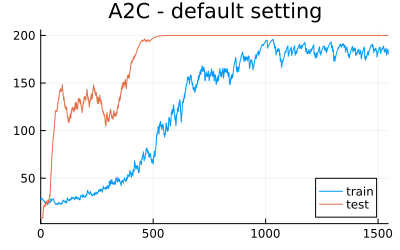

In [28]:
Plots.gr(size=(400, 250))
train_rew, test_rew = main(200000, PolGradCfg(), A2c());
plot_results(train_rew, test_rew, "A2C - default setting")


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:02

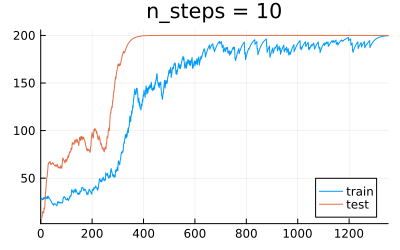

In [37]:
tr, te = main(200000, PolGradCfg(;n_steps=10), A2c());
plot_results(tr, te, "n_steps = 10")

Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:00:01

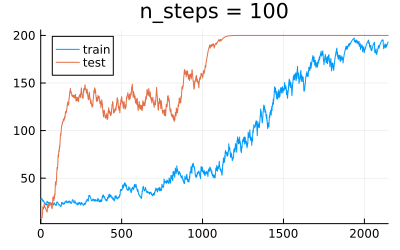

In [38]:
tr, te = main(200000, PolGradCfg(;n_steps=100), A2c());
plot_results(tr, te, "n_steps = 100")

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:01

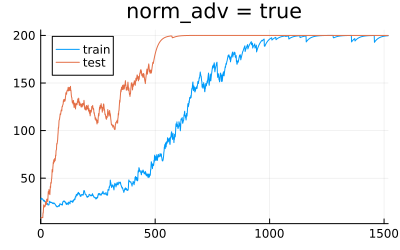

In [39]:
tr1, te1 = main(200000, PolGradCfg(;norm_adv=true), A2c());
plot_results(tr1, te1, "norm_adv = true")

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:01

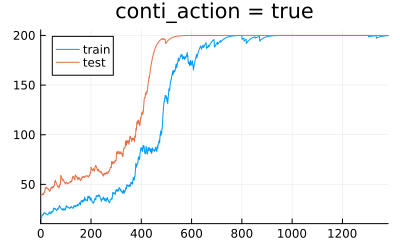

In [40]:
tr2, te2 = main(200000, PolGradCfg(;conti_action=true), A2c());
plot_results(tr2, te2, "conti_action = true")

### 5.3.3. PPO

코드 구현

In [41]:
Base.@kwdef mutable struct Ppo
    clip::Float32 = 0.1
    iter::Int64 = 10
    max_kl::Float32 = 0.01
    curr_kl::Float32 = 0
end

Ppo

In [42]:
function get_policy_objective(batch, sltd_logp, ppo::Ppo)
    ppo.curr_kl = SB.mean(batch.logp .- sltd_logp)
    ratio = exp.(sltd_logp .- batch.logp) # batch.logp is logp_old
    clip_ratio = clamp.(ratio, 1.f0 - ppo.clip, 1.f0 + ppo.clip)
    clip_adv = clip_ratio .* batch.adv
    SB.mean(min.(ratio .* batch.adv, clip_adv))
end

get_policy_objective (generic function with 2 methods)

카트폴 결과

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:02

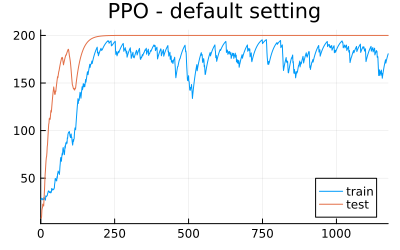

In [43]:
Plots.gr(size=(400, 250))
train_rew, test_rew = main(200000, PolGradCfg(), Ppo());
plot_results(train_rew, test_rew, "PPO - default setting")


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:04

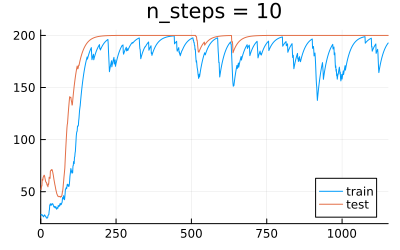

In [44]:
tr, te = main(200000, PolGradCfg(;n_steps=10), Ppo());
plot_results(tr, te, "n_steps = 10")

Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:00:01

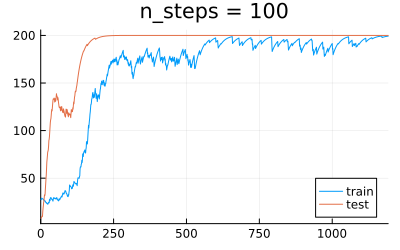

In [45]:
tr, te = main(200000, PolGradCfg(;n_steps=100), Ppo());
plot_results(tr, te, "n_steps = 100")

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:02

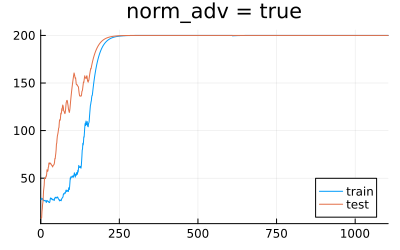

In [46]:
tr1, te1 = main(200000, PolGradCfg(;norm_adv=true), Ppo());
plot_results(tr1, te1, "norm_adv = true")

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:01

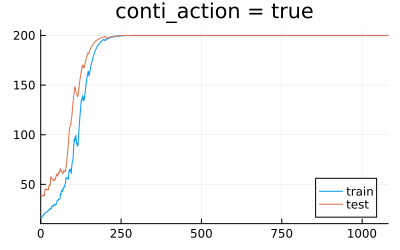

In [47]:
tr2, te2 = main(200000, PolGradCfg(;conti_action=true), Ppo());
plot_results(tr2, te2, "conti_action = true")